# Dataset from Kaggle

https://www.kaggle.com/datasets/piyushagni5/monthly-sales-of-french-champagne

# Import Library

In [1]:
# !pip install statsmodels --upgrade
import math
import warnings
import numpy as np
import pandas as pd
from math import sqrt
import tensorflow as tf
from datetime import datetime
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from keras.preprocessing.sequence import TimeseriesGenerator
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
warnings.filterwarnings('ignore')

# Load the Dataset

In [2]:
dataset = pd.read_csv("monthly_champagne_sales.csv")
dataset.head()

,Month,Sales
0,1964-01,2815
1,1964-02,2672
2,1964-03,2755
3,1964-04,2721
4,1964-05,2946


In [3]:
# Rename the columns name
dataset.rename(columns={"Month": "Date", "Sales": "Total_Sales"}, inplace = True)

In [4]:
# Information of the dataset such as number of samples, colmns, data type, Non-Null value and how much memory size use.
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         105 non-null    object
 1   Total_Sales  105 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ KB


In [5]:
# Convert the date column to a datetime object and set it as the index
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset.set_index('Date', inplace=True)
dataset.head()

,Total_Sales
Date,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


In [6]:
dataset.shape

(105, 1)

In [7]:
# Check duplicate index
dataset.index.duplicated().sum()

0

In [8]:
dataset.describe()

,Total_Sales
count,105.000000
mean,4761.152381
std,2553.502601
min,1413.000000
25%,3113.000000
50%,4217.000000
75%,5221.000000
max,13916.000000


# Visualize the Data

<Axes: xlabel='Date'>

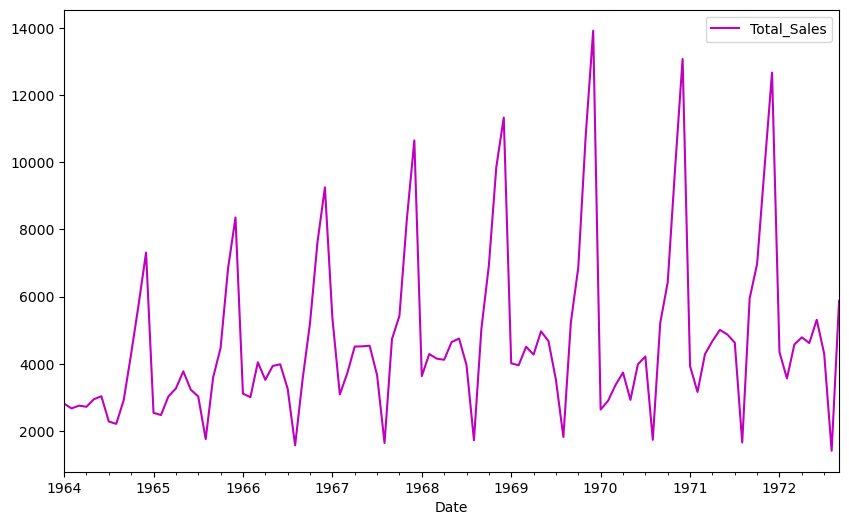

In [9]:
dataset.plot(figsize = (10,6), color = 'm')

# Data Preprocessing

Check Missing Value of the dataset

In [10]:
dataset.isnull().sum()

Total_Sales    0
dtype: int64

In [11]:
def observe_missing_value(condition, color1, color2):
    dataset.Total_Sales.plot(figsize = (10,6), color=color1, label = "Sales Data")
    plt.title(f'"{condition}"', pad = 10, color = color2)
    plt.legend(loc='upper left')
    plt.xlabel("Date")
    plt.ylabel("Total Sales")
    plt.show();

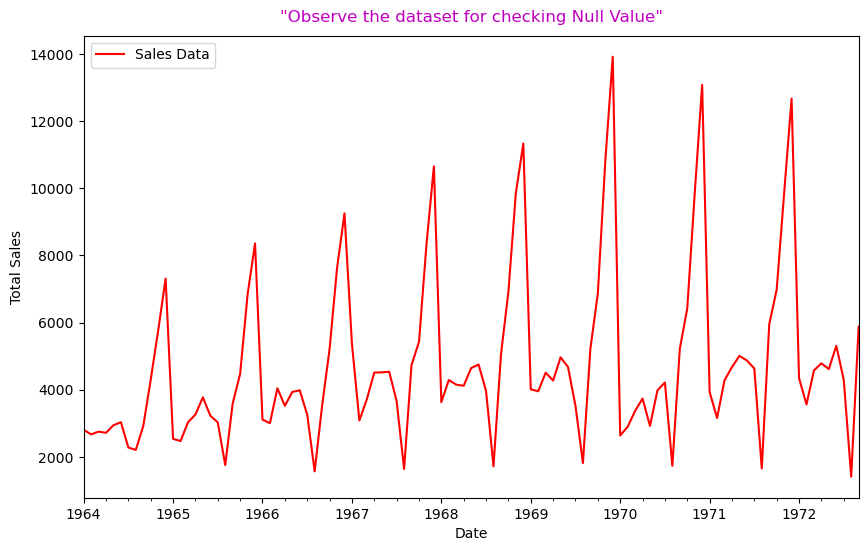

In [12]:
observe_missing_value("Observe the dataset for checking Null Value", 'r', 'm')

In [13]:
# Remove Null Value
# dataset = dataset.ffill() #interpolate()

Rolling/Moving Average

Text(0, 0.5, 'Average Sales')

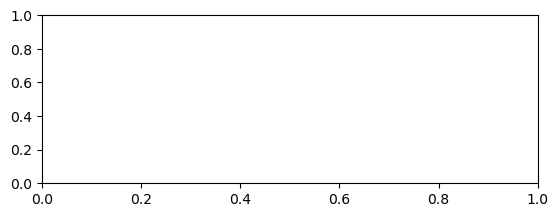

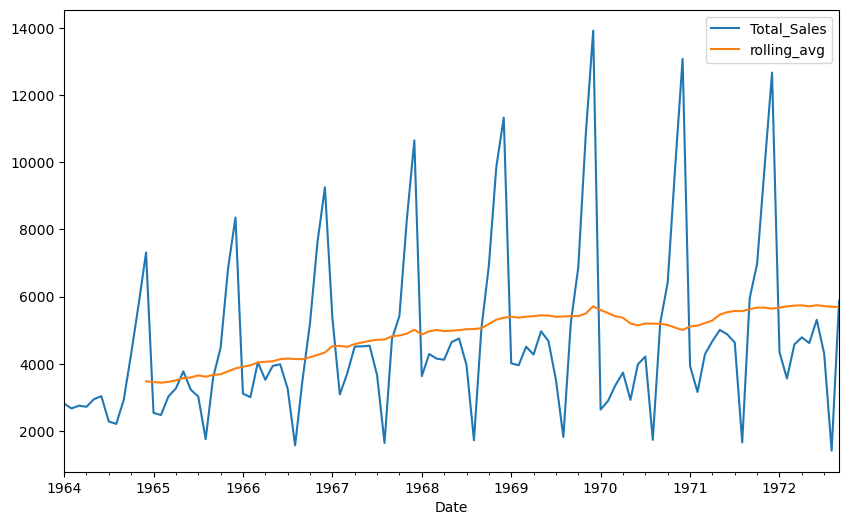

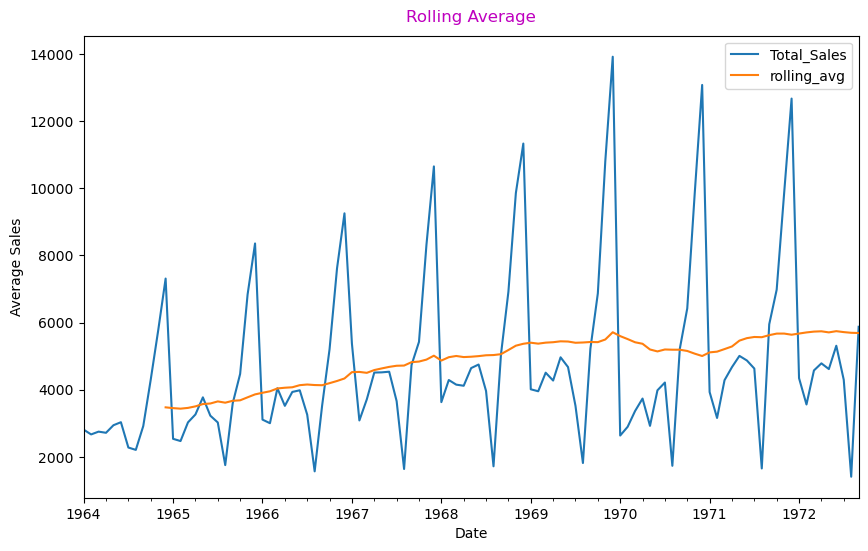

In [14]:
dataset['rolling_avg'] = dataset.Total_Sales.rolling(12).mean()
plt.subplot(2,1,1)
dataset[["Total_Sales", "rolling_avg"]].plot(figsize=(10,6))
plt.subplot
dataset[["Total_Sales", "rolling_avg"]].plot(figsize=(10,6))
plt.title("Rolling Average", pad = 10, c = 'm')
plt.ylabel("Average Sales")

In [15]:
dataset

,Total_Sales,rolling_avg
Date,,
1964-01-01,2815,NaN
1964-02-01,2672,NaN
1964-03-01,2755,NaN
1964-04-01,2721,NaN
1964-05-01,2946,NaN
...,...,...
1972-05-01,4618,5709.500000
1972-06-01,5312,5746.000000
1972-07-01,4298,5718.083333


Dickey Fuller Test for testing Stationary

In [16]:
def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

        
adfuller_test(dataset['Total_Sales'])

ADF Test Statistic : -1.8335930563276297
p-value : 0.3639157716602417
#Lags Used : 11
Number of Observations Used : 93
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


Differencing for getting Stationary

In [17]:
dataset['Sales First Difference']=dataset['Total_Sales']-dataset['Total_Sales'].shift(1)

dataset['Seasonal First Difference']=dataset['Total_Sales']-dataset['Total_Sales'].shift(12)
dataset.head(15)

,Total_Sales,rolling_avg,Sales First Difference,Seasonal First Difference
Date,,,,
1964-01-01,2815,NaN,NaN,NaN
1964-02-01,2672,NaN,-143.0,NaN
1964-03-01,2755,NaN,83.0,NaN
1964-04-01,2721,NaN,-34.0,NaN
1964-05-01,2946,NaN,225.0,NaN
1964-06-01,3036,NaN,90.0,NaN
1964-07-01,2282,NaN,-754.0,NaN
1964-08-01,2212,NaN,-70.0,NaN
1964-09-01,2922,NaN,710.0,NaN


In [18]:
adfuller_test(dataset['Seasonal First Difference'].dropna())

ADF Test Statistic : -7.626619157213163
p-value : 2.060579696813685e-11
#Lags Used : 0
Number of Observations Used : 92
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


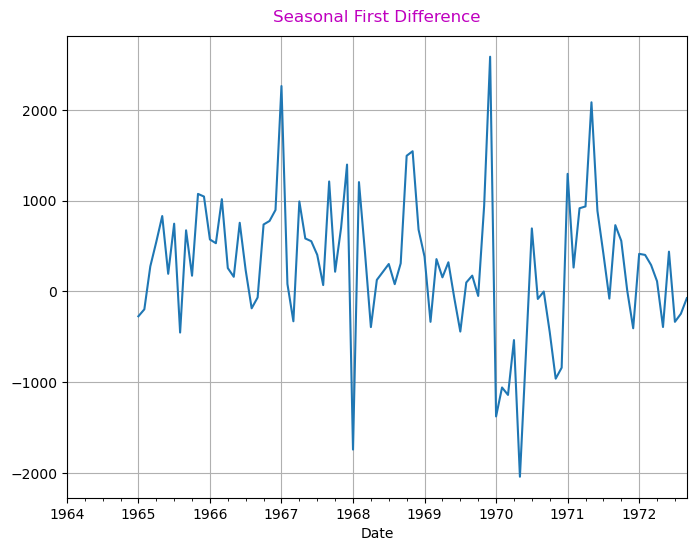

In [19]:
dataset["Seasonal First Difference"].plot(figsize=(8,6))
plt.title("Seasonal First Difference", pad = 10, c = 'm')
plt.grid()

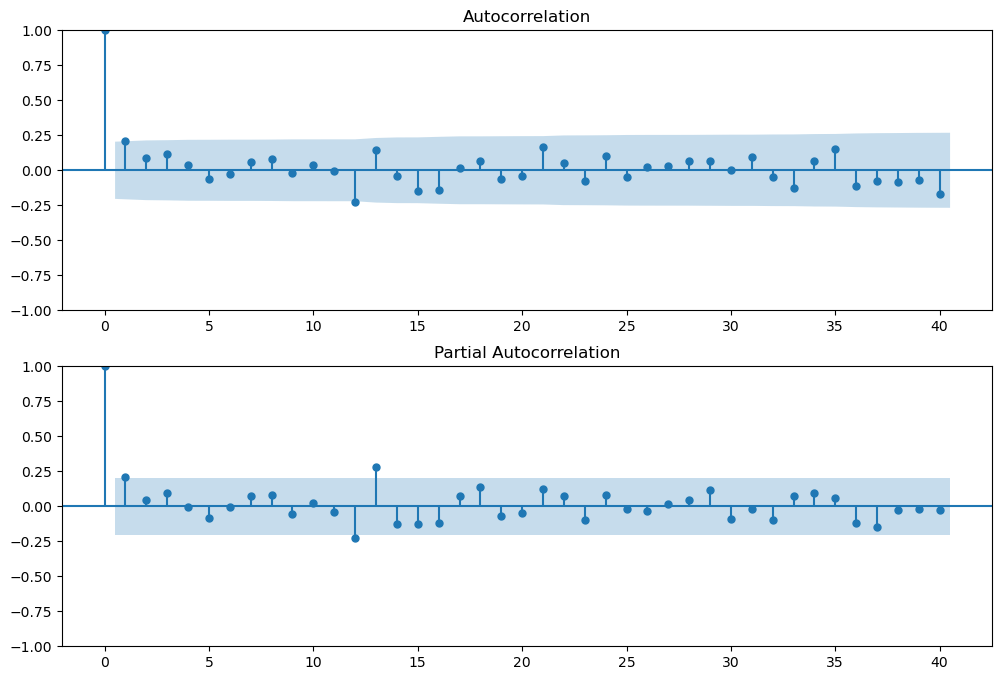

In [20]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(2,1,1)
fig = plot_acf(dataset['Seasonal First Difference'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(2,1,2)
fig = plot_pacf(dataset['Seasonal First Difference'].iloc[13:],lags=40,ax=ax2)

In [21]:
training_size = int(len(dataset)*0.9)
train_data, test_data = dataset[0:training_size],dataset[training_size:len(dataset)-1] 

Find the Best SARIMA Order

In [22]:
from pmdarima import auto_arima
step_wise_fit = auto_arima(dataset["Total_Sales"], trace = True, supress_warnings = True)
step_wise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1937.732, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1938.874, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1937.889, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1935.750, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.476 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  105
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -966.875
Date:                Fri, 22 Sep 2023   AIC                           1935.750
Time:                        09:05:23   BIC                           1938.394
Sample:                    01-01-1964   HQIC                          1936.821
                         - 09-01-1972                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      6.895e+06   5.29e+05     13.025      0.000    5.86e+06    7.93e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.86   Jarque-Bera (JB):               139.51
Prob(Q):                              0.35   Prob(JB):                         0.00
Heteroskedasticity (H):               4.62   Skew:                            -1.74
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Model Selection & Training

SARIMA Model

In [23]:
import statsmodels.api as sm
# model=sm.tsa.statespace.SARIMAX(train_data['Total_Sales'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
model=sm.tsa.statespace.SARIMAX(train_data['Total_Sales'],order=(0, 1, 0),seasonal_order=(0,1,0,12))
results=model.fit()

Text(0.5, 1.0, 'Prediction vs Test Data of SARIMA Model')

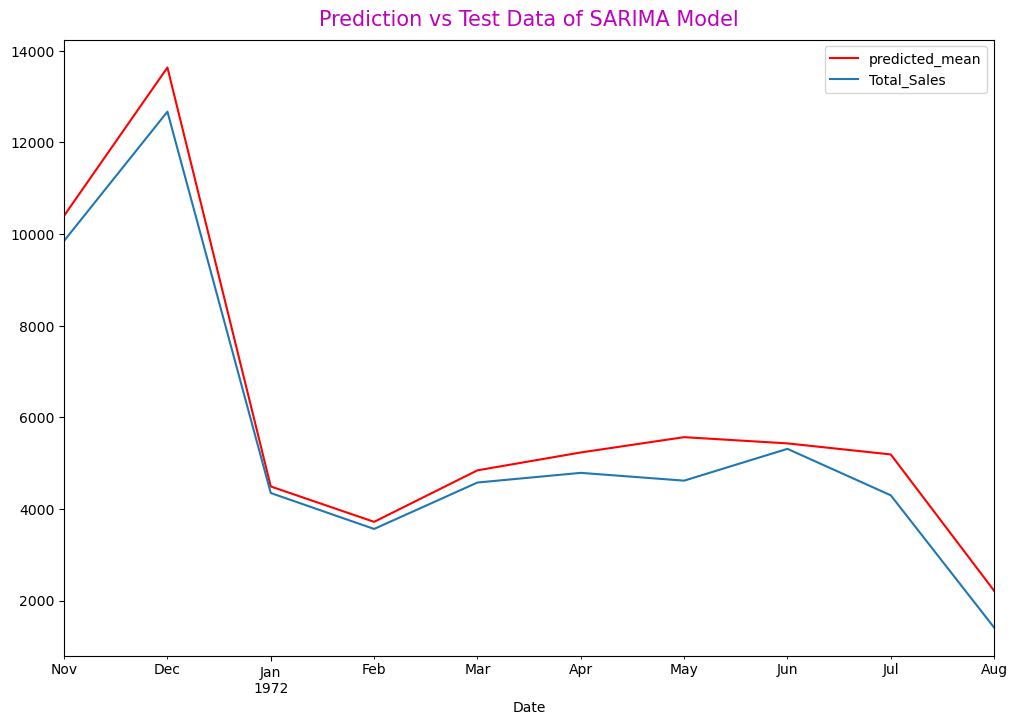

In [24]:
prediction = results.predict(start=len(train_data),end=len(train_data)+len(test_data)-1,dynamic=True)
#print(prediction)
prediction.plot(figsize=(12,8), legend = True, c = 'r')
test_data['Total_Sales'].plot(figsize=(12,8), legend = True)
plt.title('Prediction vs Test Data of SARIMA Model', color = 'm', size = 15, pad = 10)

# Model Evaluation

In [25]:
print("Mean of Test Data: ", test_data["Total_Sales"].mean())
root_mean_square_error = sqrt(mean_squared_error(test_data["Total_Sales"], prediction))
print("Mean Suare Error of SARIMA Model : ", root_mean_square_error)

Mean of Test Data:  5543.9
Mean Suare Error of SARIMA Model :  624.1925183787445


# Future Data

In [56]:
from pandas.tseries.offsets import DateOffset
print(dataset.index[-1])
future_dates=[dataset.index[-1]+ DateOffset(months=x+1)for x in range(0,1)]
future_dates

1972-09-01 00:00:00


[Timestamp('1972-10-01 00:00:00')]

In [57]:
future_datest_df=pd.DataFrame(index=future_dates[0:],columns=dataset.columns)
future_datest_df

,Total_Sales,rolling_avg,Sales First Difference,Seasonal First Difference
1972-10-01,NaN,NaN,NaN,NaN


In [58]:
future_df=pd.concat([dataset,future_datest_df])
future_df

,Total_Sales,rolling_avg,Sales First Difference,Seasonal First Difference
1964-01-01,2815,NaN,NaN,NaN
1964-02-01,2672,NaN,-143.0,NaN
1964-03-01,2755,NaN,83.0,NaN
1964-04-01,2721,NaN,-34.0,NaN
1964-05-01,2946,NaN,225.0,NaN
...,...,...,...,...
1972-06-01,5312,5746.000000,694.0,438.0
1972-07-01,4298,5718.083333,-1014.0,-335.0
1972-08-01,1413,5697.583333,-2885.0,-246.0
1972-09-01,5877,5691.416667,4464.0,-74.0


1972-09-01    5877.0
1972-10-01    7538.0
Name: forecast, dtype: float64


<Axes: >

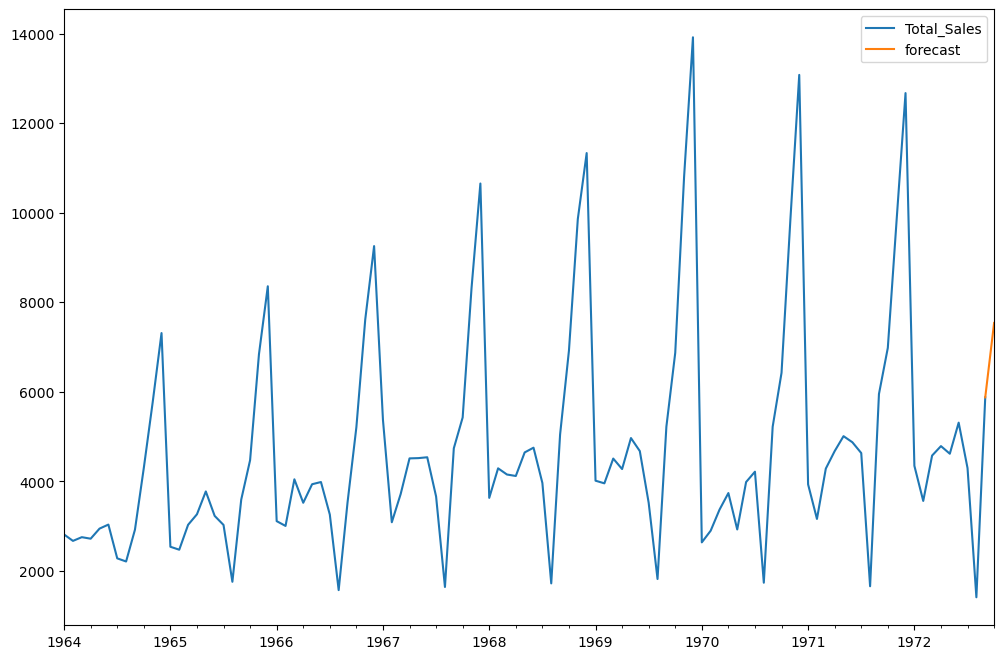

In [67]:
future_df['forecast'] = results.predict(start = len(dataset), end = 120, dynamic= True)
future_df['forecast'].iloc[len(dataset)-1] = future_df["Total_Sales"][len(dataset)-1]
print(future_df['forecast'][-2:])
future_df[['Total_Sales', 'forecast']].plot(figsize=(12, 8)) 

In [52]:
future_df


,Total_Sales,rolling_avg,Sales First Difference,Seasonal First Difference,forecast
1964-01-01,2815,NaN,NaN,NaN,NaN
1964-02-01,2672,NaN,-143.0,NaN,NaN
1964-03-01,2755,NaN,83.0,NaN,NaN
1964-04-01,2721,NaN,-34.0,NaN,NaN
1964-05-01,2946,NaN,225.0,NaN,NaN
...,...,...,...,...,...
1972-07-01,4298,5718.083333,-1014.0,-335.0,NaN
1972-08-01,1413,5697.583333,-2885.0,-246.0,NaN
1972-09-01,5877,5691.416667,4464.0,-74.0,NaN
1972-09-01,NaN,NaN,NaN,NaN,NaN


In [38]:
future_df.tail()

,Total_Sales,rolling_avg,Sales First Difference,Seasonal First Difference,forecast
1972-07-01,4298,5718.083333,-1014.0,-335.0,NaN
1972-08-01,1413,5697.583333,-2885.0,-246.0,NaN
1972-09-01,5877,5691.416667,4464.0,-74.0,NaN
1972-10-01,NaN,NaN,NaN,NaN,7538.0
1972-11-01,NaN,NaN,NaN,NaN,10956.0


# LSTM Model

In [ ]:
train_data = train_data.drop(["rolling_avg", "Sales First Difference",  "Seasonal First Difference"], axis = 1)
test_data = test_data.drop(["rolling_avg", "Sales First Difference",  "Seasonal First Difference"], axis = 1)

In [ ]:
tf.keras.utils.set_random_seed(1)
# Data Scaling
scaler = MinMaxScaler()

In [ ]:
scaler.fit(train_data)
scaled_train = scaler.transform(train_data)
scaled_test = scaler.transform(test_data)

In [ ]:
n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length = n_input, batch_size= 1)

In [ ]:
#Define Model
model = Sequential()
model.add(LSTM(100, activation = 'relu', input_shape = (n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer="adam", loss = 'mse')

In [ ]:
model.summary()

In [ ]:
#fit model
model.fit(generator, epochs = 600)

In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch, c = "r", label = "Loss")
plt.title('Loss per epoch', color = 'red', size = 15, pad = 10)
plt.legend()
     

In [ ]:
last_train_batch = scaled_train[-n_input:]

In [ ]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [ ]:
model.predict(last_train_batch)

In [ ]:
scaled_test.shape

In [ ]:
test_predictions = []
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))
for i in range(len(test_data)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis = 1)

In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)

In [ ]:
test_data["Predictions"] = true_predictions

In [ ]:
test_data.plot(figsize = (12,6),)
plt.title('Total Sales of Test Data vs Predictions', color = 'red', size = 15, pad = 10);

In [ ]:
root_mean_square_error = sqrt(mean_squared_error(test_data['Total_Sales'], test_data["Predictions"]))
print("Root Mean Square Error of LSTM Model ", root_mean_square_error)

#### 